---

## 11.3.3 Processing words as a sequence: The sequence model approach

In [1]:
import os, sys, pathlib, shutil, random
import numpy as np

from IPython.display import YouTubeVideo

import tensorflow as tf

In [2]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive') # 'My Drive' is the default name of Google Drives, change the rest accordingly!
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/6-text-and-sequences') 
    os.listdir() 

---

### Word embeddings

A big revolution of this last decade: researchers discovered that we can get systems to **learn to project words** into a **vector space** that retain **semantic relationship**.

The idea behind this discovery is that **similar words** (similar meanings) occur in **similar contexts**.

*You shall know a word by the company it keeps.*  
(J. R. Firth, "A Synopsis of Linguistic Theory", 1957, cf. also the late Wittgenstein)

The algorithms will train on large text corpora, and:
- count all the occurrences of words and contexts;  
- try and predict either the word given the context;
- or the context given the word.

Word embeddings in the context of a large dictionary have typically 256, 512 or 1024 dimensions  
(the dimension of a vector is its length i.e. the number of components).

One-hot encoded vectors can exceed 20,000 dimensions!  
Also, technically all one-hot encoded are **orthogonal**: no similarity between them.

Word embeddings compress the information into fewer dimensions.  
Two word vectors can be compared to each other!

<!-- <img style="height: 700px" src="images/nlp/chollet.one-hot-embeddings.png"> -->
<img src="https://drive.google.com/uc?id=1wFVlsvlZMqoTcM_dDRnX3QKvL9nAmOJy">

<small>DLWP, p.330</small>

|One-hot|Word embeddings|
|:---|:---|
|binary (integers: 0/1)|floating point vectors|
|sparse (most elements are zeros)|*dense*|
|very high-dimensional|low-to-medium-dimensional|
|hard-coded|learnt from data|


The results is that each token will be represented as a **coordinate** (aka a **vector**) in a high-dimensional space.

The most striking features of these spaces is that they seem to encode **semantic relationships**!

<!-- <img src="images/nlp/linear-relationships.svg"> -->
<img src="https://drive.google.com/uc?id=1qsmSHdJxMYmnapU0br6ESLc69deKedcj">


<small>[Embeddings: Translating to a Lower-Dimensional Space, Google Foundational Courses, Machine Learning, Embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space)</small>

#### Note 

A universal embedding is unlikely, or very difficult to achieve.

Semantic relationships depend on task – the text corpus and what we are learning.

Expect different geometries for different tasks (e.g. sentiment analysis is very different from classification of legal documents).

#### Also

The biases of your dataset **will be encoded** in the space (for instance, gendered associations between professions).

### References

#### Word2Vec

Google, 2013, aka the Skip-Gram model, or Continuous Bag of Words (CBOW)

<small>[Mikolov et al., "Distributed Representations of Words and Phrases and their Compositionality", arxiv](https://arxiv.org/abs/1310.4546)</small>  

Perhaps the most famous word embedding scheme.

#### GloVe: *Global Vectors for Word Representation*

Stanford University, 2014

<small>[Pennington et al., "GloVe: Global Vectors for Word Representation", arxiv](https://nlp.stanford.edu/pubs/glove.pdf)</small>  


Based on factorizing a matrix of word co-occurrence statistics.

Millions of English tokens harvested from Wikipedia and other sources. 

#### Tutorial

[Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) (3D embeddings with TensorBoard!)

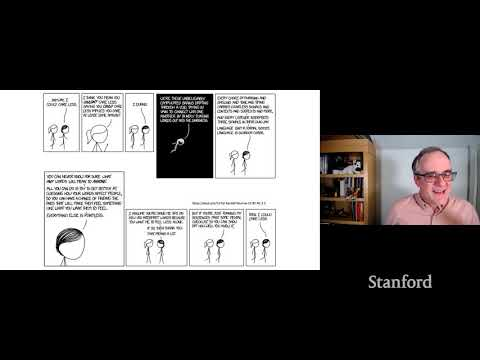

In [3]:
YouTubeVideo('rmVRLeJRkl4', width=853, height=480) #  Stanford CS224N: NLP with Deep Learning | Winter 2021 |
                                                   #  Lecture 1 - Intro & Word Vectors 

#### Learning word embeddings with the Embedding layer

Later, researchers discovered that you can simply **learn** these vectors with your DL model using backprop like everything else!

In current models, you just invoke a specific layer, and all the work is done for you.

Note that you must specify in advance the **dimensionality** of the embedding space.

As usual, more dimensions == more **resolution** (finer-grained), but more computationally expensive.

In [4]:
max_tokens = 8000
inputs = tf.keras.Input(shape=(max_tokens,))
embedding_layer = tf.keras.layers.Embedding( # ← EMBEDDING LAYER
    input_dim=max_tokens,                    # the size of the vocabulary (8000)
    output_dim=256                           # the dimensionality of the embedding space
)
x = embedding_layer(inputs)
model = tf.keras.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000)]            0         
                                                                 
 embedding (Embedding)       (None, 8000, 256)         2048000   
                                                                 
Total params: 2048000 (7.81 MB)
Trainable params: 2048000 (7.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The two arguments of the embedding layer code are:

```python
tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=256)
```

- input_dim = 8000 (the size of our vocab)
- output_dim = 256 (the dimension of the embedding space)

In Chollet's example (the IMDB sentiment task again), reviews have been reduced (or expanded) to a constant length of 600 words.

E.g. `x_test[0] = [65, 16, 38, 1334, 88, 12, ..., 16, 5345, 19, 178, 32]`

65, 16, 38... are dictionary entries – word 65, word 16, word 38... in the 8000-words dictionary.

Then, each elements of `x_test[0]` is one-hot encoded => 600 one-hot vectors of length 8000.

The embedding layer multiplies each one-hot vector by a matrix of dimensions $256 \times 8'000$ => 600 floating point vectors of length 256.

How many learnable parameters does the embedding weight matrix have?

$$
\bbox[5px,border:2px solid red]
{
\mathrm{input\_dim} \times \mathrm{output\_dim}
}
$$

Example: 

$ 8 \times 10'000 = 80'000$ elements.



The embedding layer takes as input tensors of shape `(batch_size, sequence_length)`.  
The outputs tensors of shape `(bach_size, sequence_length, output_dim)`. 

As usual in Keras, the batch_size is represented as `None`: 

$$
\bbox[5px,border:2px solid red]
{
In: (None, sequence\_length) \to Out: (None, sequence\_length, output\_dim)
}
$$

`output_dim` could be called `embed_dim`, the number of dimensions of our embedding space!



### A first practical example

Sentimenta analysis on the IMDB dataset.

#### Downloading the data

Commands to download and uncompress the imdb dataset:

```bash
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
```

#### Reminders

- in Jupyter, use a bang (!) to run a bash command. You can also run them in a terminal (without the initial !);
- in Colab, don't forget to mount your Google drive!

#### Other reminders

- You can use symlinks in Linux to avoid downloading things twice!

    ```bash
    # will create a folder called 'dataset' in the current dir, linked to the other one
    !ln -s /path/to/already/downloaded/dataset 
    ```
     
- In Google drive, the same can be achieved by selecting the directory you want to link to, and pressing Shift+Z, then selecting the target directory.

In [5]:
# code to split the data into train/val folders
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

for category in ("neg", "pos"):
    if not os.path.isdir(val_dir / category):    # do this only once
        os.makedirs(val_dir / category)          # make 'neg'/'pos' dir in validation
        files = os.listdir(train_dir / category) # list files in 'train'
        random.Random(1337).shuffle(files)       # shuffle using a seed
        num_val_samples = int(0.2 * len(files))  # 2% of our samples for validation
        val_files = files[-num_val_samples:]
        for fname in val_files:                  # move our files
            shutil.move(train_dir / category / fname,
                        val_dir / category / fname)

The [`tf.keras.utils.text_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory) layer, for a directory structure like so:
```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

In [6]:
batch_size = 32

# each of these iterables returns tuples containing two tensors:
# samples, shape: (batch_size, sample_shape) ← our texts
# targets, shape: (batch_size,)              ← 0 or 1
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size
)
val_ds = tf.keras.utils.text_dataset_from_directory(
    val_dir, batch_size=batch_size
)
test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [7]:
# Preparing integer sequence train/val/test datasets
max_length = 600   # we cut our sequences to 600 words max! (For memory.) This will affect performance...
max_tokens = 8000

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [8]:
# A sequence model built on one-hot encoded vector sequences

inputs = tf.keras.Input(shape=(None,), dtype="int64")
# ↓ our one-hot vectors --------------------------------------------
embedded = tf.one_hot(
    inputs,
    depth=max_tokens  # we have a vocabulary size of `max_tokens`
)
# ---------------------------------------------------- passed here ↓ 
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 8000)        0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2056448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2056513 (7.84 MB)
Trainable params: 2056513 (7.84 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [10]:
# Training a first basic sequence model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "one_hot_bidir_lstm.h5"),  # NOTE: in DLWP, he uses the current `.keras` format, but ModelCheckpoint
        save_best_only=True                       # in TF 2.13 now breaks when using it with `save_best_only`...
    )                                             # see: https://github.com/keras-team/tf-keras/issues/151
]
model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
625/625 [==============================] - 115s 166ms/step - loss: 0.5714 - accuracy: 0.6927 - val_loss: 0.4670 - val_accuracy: 0.7884
Epoch 2/10


/home/jcw/anaconda3/envs/gold/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 105s 168ms/step - loss: 0.3716 - accuracy: 0.8576 - val_loss: 0.3055 - val_accuracy: 0.8766
Epoch 3/10
625/625 [==============================] - 106s 169ms/step - loss: 0.3104 - accuracy: 0.8875 - val_loss: 0.3912 - val_accuracy: 0.8174
Epoch 4/10
625/625 [==============================] - 106s 170ms/step - loss: 0.2791 - accuracy: 0.9006 - val_loss: 0.4427 - val_accuracy: 0.8140
Epoch 5/10
625/625 [==============================] - 108s 173ms/step - loss: 0.2548 - accuracy: 0.9101 - val_loss: 0.3583 - val_accuracy: 0.8840
Epoch 6/10
625/625 [==============================] - 109s 174ms/step - loss: 0.2383 - accuracy: 0.9183 - val_loss: 0.2793 - val_accuracy: 0.8914
Epoch 7/10
625/625 [==============================] - 110s 175ms/step - loss: 0.2216 - accuracy: 0.9247 - val_loss: 0.2895 - val_accuracy: 0.8868
Epoch 8/10
625/625 [==============================] - 111s 177ms/step - loss: 0.2010 - accuracy: 0.9314 - val_loss: 0.2918 - val_accura

In [11]:
model = tf.keras.models.load_model(base_dir / "one_hot_bidir_lstm.h5")
print(f"Test acc: {model.evaluate(int_test_ds, verbose=0)[1]:.3f}")
del model

Test acc: 0.880


#### Learning word embeddings with the Embedding layer

In [12]:
# A model that uses an `Embedding` layer trained from scratch

tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(None,), dtype="int64")
# ↓ our embedding layer --------------------------------------------
embedded = tf.keras.layers.Embedding(
    input_dim=max_tokens, # our data comes in with a vocab size of `max_tokens`
    output_dim=256        # and comes out as dense vectors of dim ("vocab") of 256
)(inputs)
# ---------------------------------------------------- passed here ↓ 
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

Note that given our vocabulary of $8'000$ tokens the embedding layer is **large**: $256 \times 8'000 = 20'480'000$ elements.

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2048000   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2122049 (8.09 MB)
Trainable params: 2122049 (8.09 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [14]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "embeddings_bidir_lstm.h5"),
        save_best_only=True
    )
]
model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
625/625 [==============================] - 209s 322ms/step - loss: 0.5316 - accuracy: 0.7318 - val_loss: 0.3738 - val_accuracy: 0.8436
Epoch 2/10
625/625 [==============================] - 106s 169ms/step - loss: 0.3750 - accuracy: 0.8528 - val_loss: 0.4598 - val_accuracy: 0.8414
Epoch 3/10
625/625 [==============================] - 79s 126ms/step - loss: 0.3094 - accuracy: 0.8859 - val_loss: 0.3245 - val_accuracy: 0.8750
Epoch 4/10
625/625 [==============================] - 72s 116ms/step - loss: 0.2748 - accuracy: 0.9007 - val_loss: 0.3408 - val_accuracy: 0.8594
Epoch 5/10
625/625 [==============================] - 66s 106ms/step - loss: 0.2424 - accuracy: 0.9144 - val_loss: 0.3234 - val_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 70s 112ms/step - loss: 0.2228 - accuracy: 0.9222 - val_loss: 0.3746 - val_accuracy: 0.8740
Epoch 7/10
625/625 [==============================] - 67s 107ms/step - loss: 0.2047 - accuracy: 0.9297 - val_loss: 0.3650 - val_

In [15]:
model = tf.keras.models.load_model(base_dir / "embeddings_bidir_lstm.h5")
print(f"Test acc: {model.evaluate(int_test_ds, verbose=0)[1]:.3f}") # in this case, roughly the same as one-hot
del model

Test acc: 0.856


---

### Using pretrained word embeddings

Pretrained word embeddings are useful **when training data is limited** – just as with pretrained convnets.

Very structured embeddings hopefully capture **generic structure** appropriate to diverse domains.

(The more data you can train on, the more likely your task-specific embeddings will perform better.)

Let's see how we can use GloVe embeddings in `tensorflow.keras`.

(The same method applies to Word2Vec or any other embedding technique.) 

Commands to download and uncompress the pretrained GloVe word vectors.

```bash
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove # unzip to a directory called "glove"
!rm glove.6B.zip                # remove the zip file
```

In [17]:
base_dir = pathlib.Path("glove") # I have my file in a folder called 'glove'
path_to_glove_file =  base_dir / "glove.6B.100d.txt"

In [18]:
# another Jupyter magic: use $python_variable in bash commands
!head -n 1 $path_to_glove_file
# ↓ the word "the" followed by its coordinates in a 100-dimensional space

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062


In [19]:
# parsing the GloVe word-embeddings file
embeddings_index = {}                                   # our dictionary: {'word': np.array([...coordinates..])}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)            # split: word | coordinates
        coefs = np.fromstring(coefs, "float", sep=" ")  # load string floats into numpy, space-separated
        embeddings_index[word] = coefs                  # save into dictionary

print(f"Found {len(embeddings_index):,} word vectors.")

Found 400,000 word vectors.


In [20]:
embedding_dim = 100

# we reuse the same TextVectorization object as earlier, turning our sentences into integers
# max_length: 600, max_tokens: 8000
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# preparing the GloVe word-embeddings matrix
embedding_matrix = np.zeros((max_tokens, embedding_dim))     # create a matrix (max_tokens, embedding_dim)
for word, i in word_index.items():                           # looping through our vocab
    if i < max_tokens:                                       # don't try and retrieve beyond max_tokens
        embedding_vector = embeddings_index.get(word)        # try and get the vector associated with the word
    if embedding_vector is not None:                         # if the vector exists
        embedding_matrix[i] = embedding_vector               # assign it to our matrix

In [21]:
embedding_layer = tf.keras.layers.Embedding(
    max_tokens,
    embedding_dim,        # using our embedding matrix through an initializer
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,      # WE DO NOT TRAIN IT! 
    mask_zero=True,
) 

# Given that our network is initialized randomly, the massive changes it undergoes at the beginning
# of training would certainly affect/damage the representations in our embedding matrix 
# (same scenario as with pretrained ConvNets)

In [22]:
# A model that uses a pretrained Embedding layer
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(None,), dtype="int64")
# ↓ our embedding layer --------------------------------------------
embedded = embedding_layer(inputs)
# ---------------------------------------------------- passed here ↓ 
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         800000    
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 834113 (3.18 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 800000 (3.05 MB)
_____________________

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "glove_embeddings_sequence_model.h5"),
        save_best_only=True
    )
]
model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
625/625 [==============================] - 86s 117ms/step - loss: 0.2822 - accuracy: 0.8831 - val_loss: 0.2914 - val_accuracy: 0.8744
Epoch 2/10
625/625 [==============================] - 64s 102ms/step - loss: 0.2677 - accuracy: 0.8893 - val_loss: 0.2969 - val_accuracy: 0.8760
Epoch 3/10
625/625 [==============================] - 69s 110ms/step - loss: 0.2589 - accuracy: 0.8949 - val_loss: 0.2858 - val_accuracy: 0.8820
Epoch 4/10
625/625 [==============================] - 63s 101ms/step - loss: 0.2453 - accuracy: 0.8999 - val_loss: 0.3004 - val_accuracy: 0.8720
Epoch 5/10
625/625 [==============================] - 63s 101ms/step - loss: 0.2338 - accuracy: 0.9061 - val_loss: 0.3166 - val_accuracy: 0.8700
Epoch 6/10
625/625 [==============================] - 64s 103ms/step - loss: 0.2212 - accuracy: 0.9118 - val_loss: 0.3040 - val_accuracy: 0.8742
Epoch 7/10
625/625 [==============================] - 63s 101ms/step - loss: 0.2110 - accuracy: 0.9179 - val_loss: 0.3061 - val_ac

In [30]:
# annoyance: in TF 2.13, this model fails to load in .h5 format, whilst it also fails to train when using
# the ModelCheckpoint with `save_best_only`...
# model = tf.keras.models.load_model(base_dir / "glove_embeddings_sequence_model.h5")
print(f"Test acc: {model.evaluate(int_test_ds, verbose=0)[1]:.3f}")

Test acc: 0.867


---

### NLP libraries & tools in Python

#### NLTK: the Natural Language Toolkit

NLTK is a leading platform for building Python programs to work with human language data ([website](https://www.nltk.org/)).

#### Gensim

Perhaps the best dedicated library for word vectors & similar text processing tools ([website](https://radimrehurek.com/gensim/index.html)).

#### spaCy

A a free open-source library for Natural Language Processing in Python ([website](https://spacy.io/)).

## Summary

### Word embbeddings

- **Various kinds of word encodings**:
  - **one-hot/multi-hot**: the presence of words is marked by a 1 (binary) → *sparse* & *hard-coded*
  - **word embeddings**: project words/tokens into vector spaces where collocations between words ("the company a word keeps") are modeled as the distance between vectors. → *dense* & *learnt from data*
- Two most important embedding models
    - **Word2Vec** from Google
    - **GloVe** from Stanford
- **Embedding layers** can be trained end to end with your net!
- **Pretrained embeddings** can also be used on top of your own models, like pretrained networks!
  